In [1]:
import os
import torch
import pickle
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import random

from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

from models import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(41)

In [4]:
model_name = 'AirNet'+'_'+'64HumanActivity'
# dataset_names = ['Alphabet_Salar']
dataset_names = ['HumanActivity', 'HumanActivity1']
preprocessing = True

In [5]:
label_encoder = LabelEncoder()

y = []
for i, dataset_name in enumerate(dataset_names):
    full_path = 'Datasets'+'/'+dataset_name+'.npz'
    dataset = np.load(full_path)
    if i==0:
        x = dataset['x']
    else:
        x = np.concatenate([x, dataset['x']], axis=0)
    y += list(dataset['y'])

x = np.array(x)
ndata, ntimestep, nchannels  = x.shape


In [6]:
y = label_encoder.fit_transform(y)
nclasses = len(label_encoder.classes_)
print(f'ndata: {ndata} , ntimestep: {ntimestep} , nchannels: {nchannels}')

ndata: 363 , ntimestep: 2048 , nchannels: 6


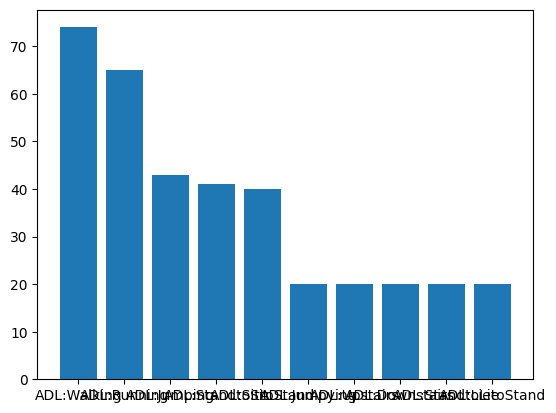

In [7]:
counts = Counter(label_encoder.inverse_transform(y))

items = list(counts.keys())
frequencies = list(counts.values())

plt.bar(items, frequencies)
plt.show()

In [8]:
label_encoder.classes_

array(['ADL:Downstairs', 'ADL:Jumping', 'ADL:Jumpying', 'ADL:LietoStand',
       'ADL:Running', 'ADL:SittoStand', 'ADL:StandtoLie',
       'ADL:StandtoSit', 'ADL:Upstairs', 'ADL:Walking'], dtype='<U14')

In [9]:
ndata_train = int(0.8*ndata)
ndata_eval = int(0.2*ndata)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=ndata_eval, random_state=42, stratify=y)

In [10]:
x_temp = x_train.reshape([-1, nchannels])
x_temp = x_temp[~np.any(np.isnan(x_temp), axis=1), :]
mean_arr = x_temp.mean(axis=0)
std_arr = x_temp.std(axis=0)

In [11]:
x_train_n = (x_train-mean_arr)/std_arr
x_eval_n = (x_eval-mean_arr)/std_arr
x_train_n[np.isnan(x_train_n)] = 0
x_eval_n[np.isnan(x_eval_n)] = 0

x_train_n = torch.tensor(x_train_n.transpose([0, 2, 1]), dtype=torch.float32)
x_eval_n = torch.tensor(x_eval_n.transpose([0, 2, 1]), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_eval = torch.tensor(y_eval, dtype=torch.long)

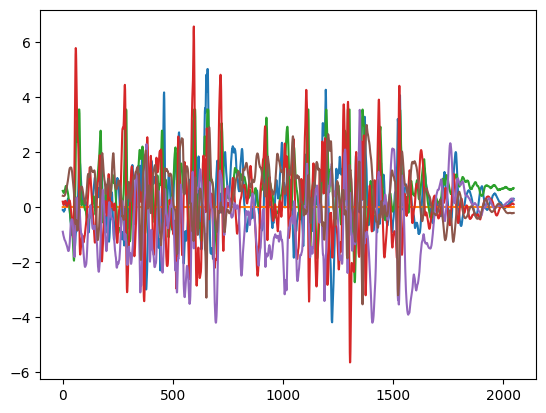

In [12]:
temp = (x_train-mean_arr)/std_arr
temp[np.isnan(temp)] = 0
plt.plot((temp[25, :, :]))
plt.show()

In [13]:
def seed_worker(worker_id):
    np.random.seed(43 + worker_id)
    random.seed(43 + worker_id)

In [14]:
train_dataset = TensorDataset(x_train_n, y_train)
eval_dataset = TensorDataset(x_eval_n, y_eval)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)
eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False, worker_init_fn=seed_worker)

In [15]:
model = globals()[model_name.split('_')[0]](nchannels=nchannels, nclasses=nclasses, preprocessing=preprocessing).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\Asus\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
nepoch = 50
train_loss_list = []
eval_loss_list = []

for epoch in range(nepoch):
    model.train()
    train_loss = 0
    for (inputs, labels) in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss/len(train_dataloader))

    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for (inputs, labels) in eval_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
    eval_loss_list.append(eval_loss/len(eval_dataloader))
    print(f'Epoch [{epoch+1}/{nepoch}], Train Loss: {train_loss_list[-1]}, Eval Loss: {eval_loss_list[-1]}')

Epoch [1/50], Train Loss: 2.094411770502726, Eval Loss: 2.2876415252685547
Epoch [2/50], Train Loss: 1.7443173329035442, Eval Loss: 2.2691869735717773
Epoch [3/50], Train Loss: 1.3714125156402588, Eval Loss: 2.2631678581237793
Epoch [4/50], Train Loss: 1.0805748502413433, Eval Loss: 2.288991928100586
Epoch [5/50], Train Loss: 0.8595158457756042, Eval Loss: 2.3323564529418945
Epoch [6/50], Train Loss: 0.6428269743919373, Eval Loss: 2.4033610820770264
Epoch [7/50], Train Loss: 0.45751697321732837, Eval Loss: 2.617769956588745
Epoch [8/50], Train Loss: 0.3174465795358022, Eval Loss: 3.290487289428711
Epoch [9/50], Train Loss: 0.22032442688941956, Eval Loss: 4.111963272094727
Epoch [10/50], Train Loss: 0.16432114069660506, Eval Loss: 3.7675352096557617
Epoch [11/50], Train Loss: 0.10780368248621623, Eval Loss: 2.637918472290039
Epoch [12/50], Train Loss: 0.07008956062297027, Eval Loss: 1.5008729696273804
Epoch [13/50], Train Loss: 0.04770162142813206, Eval Loss: 0.8836424946784973
Epoch [1

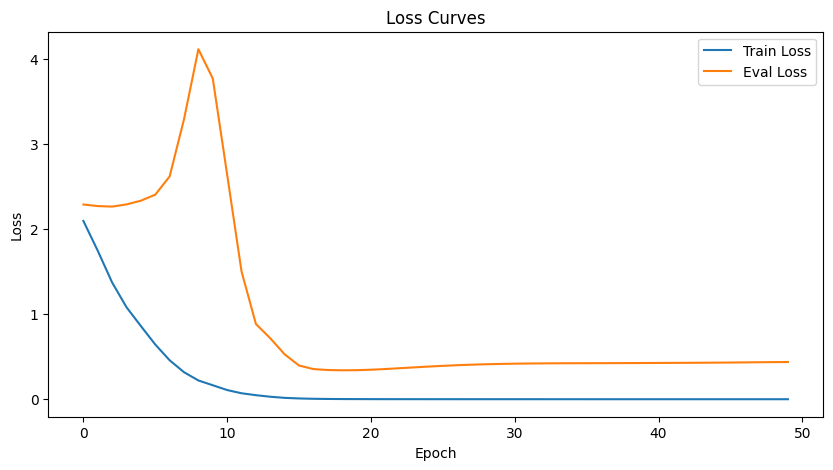

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(range(nepoch), train_loss_list, label='Train Loss')
plt.plot(range(nepoch), eval_loss_list, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

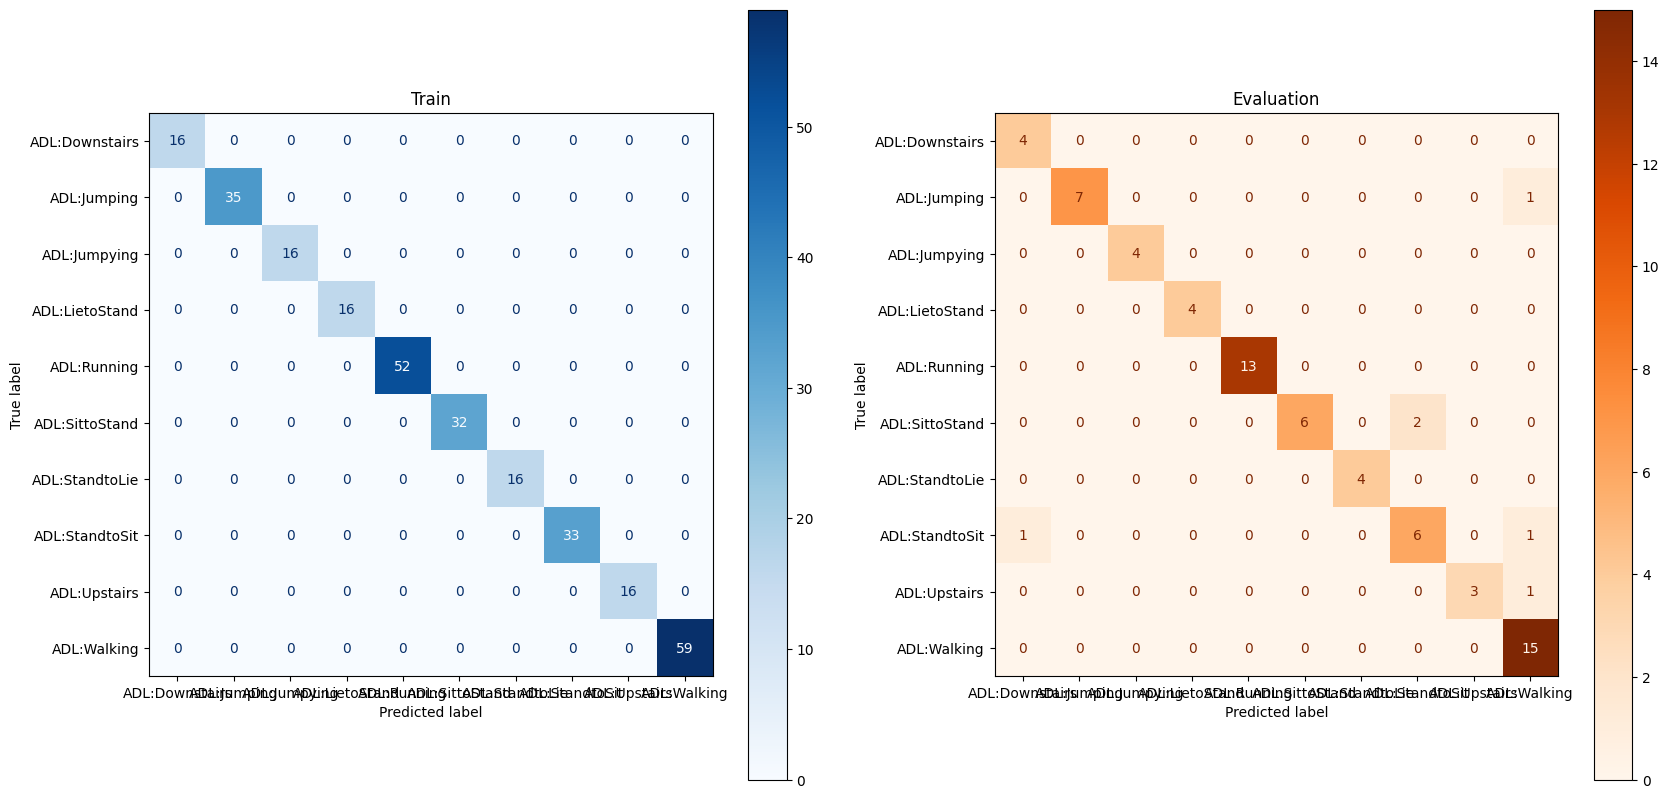

In [18]:
model.eval()
train_preds = []
train_labels = []
eval_preds = []
eval_labels = []
with torch.no_grad():
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        train_preds.append(preds.cpu())
        train_labels.append(labels.cpu())
    for inputs, labels in eval_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        eval_preds.append(preds.cpu())
        eval_labels.append(labels.cpu())

train_preds = torch.cat(train_preds)
train_labels = torch.cat(train_labels)

eval_preds = torch.cat(eval_preds)
eval_labels = torch.cat(eval_labels)

# Confusion matrix
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
cm_train = confusion_matrix(train_labels.cpu(), train_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_encoder.classes_)
disp.plot(ax=axs[0], cmap='Blues')
axs[0].set_title('Train')

cm_eval = confusion_matrix(eval_labels.cpu(), eval_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eval, display_labels=label_encoder.classes_)
disp.plot(ax=axs[1], cmap='Oranges')
axs[1].set_title('Evaluation')
# plt.tight_layout()
plt.show()

In [19]:
folder_path = 'Models'
if(input('Do you want to save the model?(y/n): ')=='y'):
        variables_full_path = folder_path+'/'+model_name+'.pkl'
        model_full_path = folder_path+'/'+model_name+'.pth'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(variables_full_path, 'wb') as f:         
            pickle.dump({'preprocessing': preprocessing, 'label_encoder': label_encoder, 'mean_arr': mean_arr, 'std_arr': std_arr}, f)
        torch.save(model.state_dict(), model_full_path)